In [2]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.math import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from tqdm import tqdm
import os

ModuleNotFoundError: No module named 'keras'

In [ ]:
# file path for X, y (combined)
path = './Output'

# file path for X, y (separated)
output_path = './temp'

In [ ]:
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(output_path) if p[:14] == 'feature_vector']), *np.load(output_path + '/feature_vector0.npy').shape

# Preproc (need to do only once)

Import data

In [3]:
X = np.load(path + '/feature_vector.npy')
Y = np.load(path + '/labels.npy')

Reshaping etc.

In [4]:
X = X.reshape(-1, 370, 100, 30).astype('float32') / 255 # normalization + dimension reshape
#plt.hist(X.reshape(-1,)) # check if it worked

In [5]:
Y = Y[:, 0] # TODO: just phF for now

Export as separate files for data generator (WARNING: takes a long time)

In [ ]:
with tqdm(total=N) as pbar:
    for i, (x, y) in enumerate(zip(X, Y)):
        np.save(output_path + f'/feature_vector{i}', X[i])
        np.save(output_path + f'/labels{i}', Y[i])
        pbar.update(1)

# Define data generator

In [4]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=int)

        # load individual datapoints
        for i, index in enumerate(indices):
            X[i, ] = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# CNN

In [5]:
# train/validation split
TRAIN_VAL_SPLIT = 0.33

permutation_indices = [i for i in range(N)]
np.random.shuffle(permutation_indices)

validation_indices = permutation_indices[:int(N * TRAIN_VAL_SPLIT)]
train_indices = permutation_indices[int(N * TRAIN_VAL_SPLIT):]

print(f'|val_set|: {len(validation_indices)}, |train_set|: {len(train_indices)}')

|val_set|: 813, |train_set|: 1653


In [6]:
# upsampling (imbalanced dataset)
Y = np.load(path + '/labels.npy')

positive_indices = np.where(Y[validation_indices, 0] == 1)[0] # TODO: only phF for now
negative_indices = np.where(Y[validation_indices, 0] == 0)[0] # TODO: only phF for now

print(f'val_set: (+: {len(positive_indices)}, -: {len(negative_indices)})\n')

positive_indices = np.where(Y[train_indices, 0] == 1)[0] # TODO: only phF for now
negative_indices = np.where(Y[train_indices, 0] == 0)[0] # TODO: only phF for now

print(f'train_set: (+: {len(positive_indices)}, -: {len(negative_indices)})')

negative_indices_upsampled = np.append(negative_indices,
                                       np.random.choice(negative_indices,
                                                        size=(len(positive_indices) - len(negative_indices)),
                                                        replace=True)) # with replacement

print(f'train_set (upsampled): (+: {len(positive_indices)}, -: {len(negative_indices_upsampled)})')

val_set: (+: 601, -: 212)

train_set: (+: 1234, -: 419)
train_set (upsampled): (+: 1234, -: 1234)


In [7]:
training_batch_generator = DataGenerator(data_path=output_path, indices_dataset=train_indices, batch_size=128)
validation_batch_generator = DataGenerator(data_path=output_path, indices_dataset=validation_indices, batch_size=1)

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(370, 100, 30), padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization()) # try for incr. stability
model.add(layers.MaxPool2D(strides=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2')) # normal weight init + l2 regularization needed?
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer='l2')) # normal weight init + l2 regularization needed?
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 370, 100, 32)      8672      
                                                                 
 conv2d_1 (Conv2D)           (None, 370, 100, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 370, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 185, 50, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 185, 50, 32)       9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 185, 50, 32)       9

In [9]:
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=20)

C:\Users\jjung\AppData\Local\Temp\ipykernel_37788\1672967617.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=training_batch_generator,


Epoch 1/20
12/12 [==============================] - 21s 1s/step - loss: 7.0689 - accuracy: 0.7044 - val_loss: 6.4121 - val_accuracy: 0.7392
Epoch 2/20
12/12 [==============================] - 17s 1s/step - loss: 5.7193 - accuracy: 0.7507 - val_loss: 5.2273 - val_accuracy: 0.7306
Epoch 3/20
12/12 [==============================] - 17s 1s/step - loss: 4.5997 - accuracy: 0.7500 - val_loss: 4.2319 - val_accuracy: 0.7392
Epoch 4/20
12/12 [==============================] - 18s 1s/step - loss: 3.7116 - accuracy: 0.7448 - val_loss: 3.4666 - val_accuracy: 0.7220
Epoch 5/20
12/12 [==============================] - 17s 1s/step - loss: 3.0095 - accuracy: 0.7624 - val_loss: 2.8614 - val_accuracy: 0.7232
Epoch 6/20
12/12 [==============================] - 16s 1s/step - loss: 2.4387 - accuracy: 0.7715 - val_loss: 2.3994 - val_accuracy: 0.7122
Epoch 7/20
12/12 [==============================] - 16s 1s/step - loss: 2.0116 - accuracy: 0.7760 - val_loss: 1.9896 - val_accuracy: 0.7392
Epoch 8/20
12/12 [==

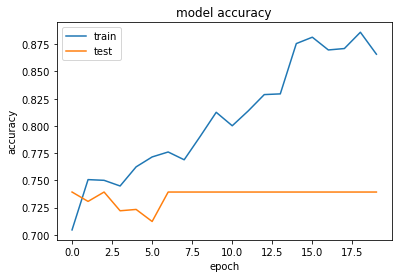

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

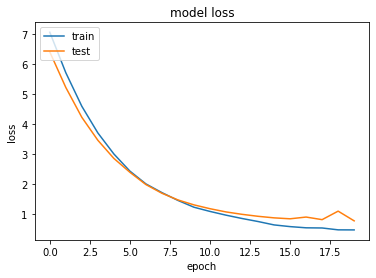

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

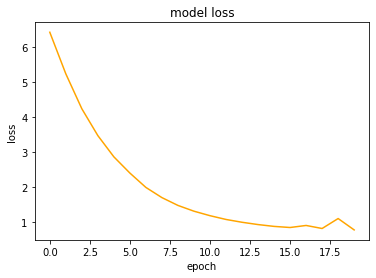

In [12]:
plt.plot(history.history['val_loss'], color='orange')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

813/813 [==============================] - 6s 8ms/step


Text(0.5, 1.0, 'Labels')

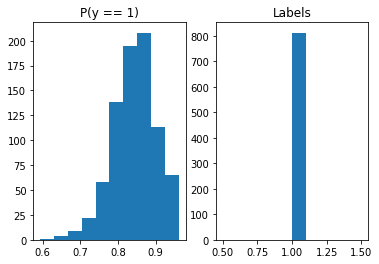

In [13]:
# predict on validation set
y_pred = model.predict(validation_batch_generator)
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

In [14]:
# classification metrics
size_validation_set = len(validation_indices)

X_val = np.empty((size_validation_set, HEIGHT, WIDTH, CHANNELS))
y_val = np.empty(size_validation_set, dtype=int)

# load individual datapoints
for i, index in enumerate(validation_indices):
    X_val[i, ] = np.load(output_path + f'/feature_vector{index}.npy', allow_pickle=True)
    y_val[i] = np.load(output_path + f'/labels{index}.npy', allow_pickle=True)

In [15]:
# confusion matrix
confusion_matrix(labels=y_val, predictions=y_pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  0, 212],
       [  0, 601]])>

In [16]:
# flush GPU memory
cuda.select_device(0)
cuda.close()